# 1. head files

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 2. import dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

/opt/miniconda3/envs/ubc_ml/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
print(f"feature shape:{mnist.data.shape}")
print(f"labels: {np.unique(mnist.target)}")

feature shape:(70000, 784)
labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [4]:
x = mnist.data
# very important !!! str->int (do not use np.uint8, will overflow!)
y = mnist.target.astype(int) 
y = y.reshape(-1,1)

## digit image example

In [5]:
print(f"image pixel range: {x.min()}, {x.max()}")
x = x / x.max() # normalization
print(f"labels: {np.unique(y)}")
for i in range(10):
    y_copy = y.copy()
    print(f"number {i}: {y_copy[y_copy==i].size} images")

image pixel range: 0.0, 255.0
labels: [0 1 2 3 4 5 6 7 8 9]
number 0: 6903 images
number 1: 7877 images
number 2: 6990 images
number 3: 7141 images
number 4: 6824 images
number 5: 6313 images
number 6: 6876 images
number 7: 7293 images
number 8: 6825 images
number 9: 6958 images


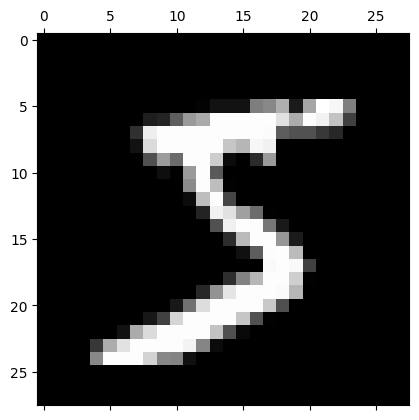

In [6]:
image_sample = x[0].reshape(28,28)
plt.matshow(image_sample, cmap='gray')

# 3. split dataset

In [7]:
seed = 42
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)
print(f"train set shape: {x_train.shape, y_train.shape}")
print(f"test set shape: {x_test.shape, y_test.shape}")

train set shape: ((56000, 784), (56000, 1))
test set shape: ((14000, 784), (14000, 1))


# 4. train model for C classes (C=10)

## define model, cost, optimization method

In [8]:
class My_LogisticRegression:
    def __init__(self, alpha=1.0, max_its=100, eps=1e-6):
        """
        alpha: learning rate
        max_its: max iteration of the training process
        n_dim: dimension of feature
        """
        self.alpha = alpha
        self.max_its = max_its
        self.eps = eps
        self.coef = None
        self.bias = None
        self.w = None
        self.cost_history = None

    def gradient_descent(self, cost_func, alpha, max_its, w, eps, decay=True):
        gradient = grad(cost_func)
        weight_history = [w]
        cost_history = [cost_func(w)]
        step_size = alpha
        for k in range(max_its):
            grad_eval = gradient(w)
            if decay:
                step_size = alpha / (k + 1)
            w = w - step_size * grad_eval / np.linalg.norm(grad_eval)
            weight_history.append(w)
            cost = cost_func(w)
            cost_history.append(cost)
            if cost < eps or k >= max_its:
                break
        return w, weight_history, cost_history
    
    def softmax_loss(self, w, x, y):
        """
        2-classification softmax
        label:{-1, 1}
        loss = \frac{1}{P}\Sigma_{p=1}^{P}log(1+e^{-y\overline{x}_p^Tw})
        """
        loss = np.log(1 + np.exp(-y * self.model(x, w)))
        return np.mean(loss)

    def model(self, x_p, w):
        """
        linear model
        """
        # w0 + w1 * x
        a = w[0] + np.dot(x_p, w[1:])
        return a

    def fit(self, x, y, opt='gradient_descent', cost_func='softmax'):
        """
        Train Logistic Regression
        opt: optimization method, default: gradient_descent
        cost_func: cost function, default: softmax (label:{-1,1})
        """   
        w = 2 * np.random.rand(x.shape[1]+1, 1) - 1    
        # cost function
        if cost_func == 'softmax':
            c = lambda w: self.softmax_loss(w, x, y)
        
        # optimization method
        if opt=='gradient_descent':
            opt_method=self.gradient_descent
        
        # training process 
        final_weights, weight_history, cost_history = opt_method(c, self.alpha, self.max_its, w, self.eps)
        self.w = final_weights
        self.coef = final_weights[1:]
        self.bias = final_weights[0]
        self.cost_history = cost_history
        return final_weights, weight_history, cost_history

    def predict_class(self, x):
        score = self.model(x, self.w)
        return np.where(score>=0, 1, -1)
    
    def predict(self, x):
        score = self.model(x, self.w)
        return score

## training process

In [9]:
model_list = []
C = 10
for c in range(C):
    x = x_train
    y = y_train.copy()
    y[y_train==c]=1
    y[y_train!=c]=-1
    model = My_LogisticRegression(alpha=1.0, max_its=1000, eps=1e-4)
    model.fit(x, y)
    print(f"Cost for class {c}: {model.cost_history[-1]}")
    model_list.append(model)


Cost for class 0: 0.04397892819729113
Cost for class 1: 0.035969401644275076
Cost for class 2: 0.1067571003518268
Cost for class 3: 0.11426036606566292
Cost for class 4: 0.08121533768063721
Cost for class 5: 0.12403342120544465
Cost for class 6: 0.05370009132762576
Cost for class 7: 0.06843675236314216
Cost for class 8: 0.20962387161103063
Cost for class 9: 0.1396914931093961


In [12]:
d = None
for c in range(10):
    x = x_train.copy()
    model = model_list[c]
    if c == 0:
        d = model.predict(x)
    else:
        d = np.concatenate((d, model.predict(x)), axis=1)

z = np.argmax(d, axis=1)
z=z.reshape(-1,1)
print(f"====Accuracy on train set====")
print(f"Correct predictions: {np.sum(z==y_train)}")
print(f"Accuracy: {np.sum(z==y_train)/y_train.shape[0]}")

====Accuracy on train set====
Correct predictions: 48884
Accuracy: 0.8729285714285714


## test process

In [13]:
d = None

for c in range(10):
    x = x_test.copy()
    model = model_list[c]
    if c == 0:
        d = model.predict(x)
    else:
        d = np.concatenate((d, model.predict(x)), axis=1)
z = np.argmax(d, axis=1)
z=z.reshape(-1,1)
print(f"Accuracy on test set")
print(f"Correct predictions: {np.sum(z==y_test)}")
print(f"Accuracy: {np.sum(z==y_test)/y_test.shape[0]}")

Accuracy on test set
Correct predictions: 12254
Accuracy: 0.8752857142857143
